# Bumping or Escaping Local Minima

*This notebook first appeared as a [blog post](//betatim.github.io/posts/bumping) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Yes, this is about machine learning and not some weird fetish. This post is totally safe for work, promise.

With that out of the way: What is bumping? Bumping is a simple algorithm that can help your classifier escape from a local minimum. Huh? Read on, after a few imports you will see what I mean.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(457)
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


def make_chessboard(N=1000,
                    xbins=(0.,0.5,1.),
                    ybins=(0.,0.5,1.)):
    """Chessboard pattern data"""
    X = np.random.uniform(size=(N,2))
    xcategory = np.digitize(X[:,0], xbins)%2
    ycategory = np.digitize(X[:,1], ybins)%2
    y = np.logical_xor(xcategory, ycategory)
    y = np.where(y, -1., 1.)

    return X,y

def plot_data(X,y):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=y)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    return (fig, ax)

## The Chess(board) Problem

Imagine your data is organised like a chessboard. Two features and two classes (black and white). A simple decision tree with two levels should be able to perfectly separate these samples.

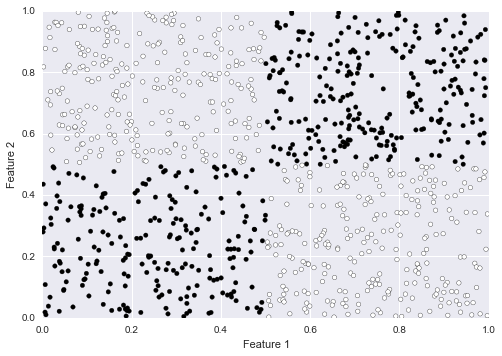

In [3]:
X_,y_ = make_chessboard(N=1000)
p = plot_data(X_,y_)

Let's train a simple decision tree and see how well it does. Then we will inspect the tree to see what it learnt. A neat feature of `scikit-learn` is the `export_graphviz` function which will draw a decision tree for you. Interpretability heaven!

In [4]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_,y_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

The following two functions help with interpreting the decision tree. The first one, `visualise_tree`, draws a decision tree. We can look at each node's decision function, how many samples were sent to the left and the right, etc.

The second function `draw_decision_regions` superimposes the prediction of the decision tree on the samples. I find this more intuative for deep trees.

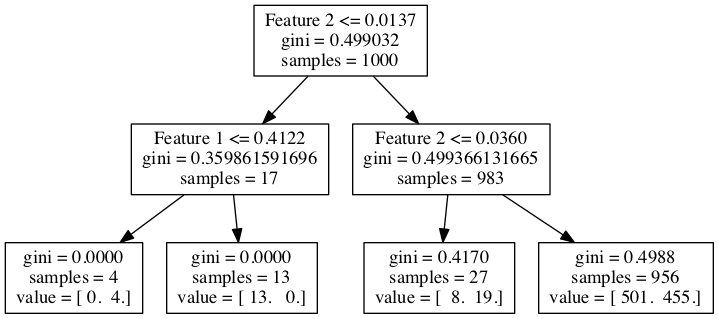

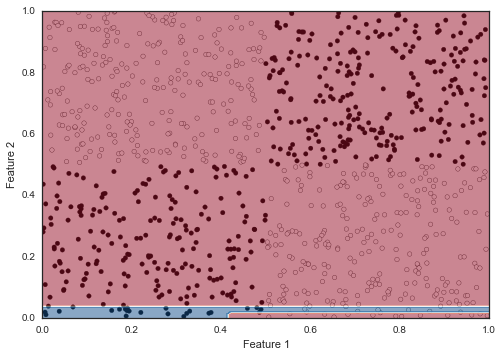

In [5]:
def visualise_tree(tree):
    """Draw the decision tree"""
    export_graphviz(tree, out_file="/tmp/tree.dot", 
                    feature_names=["Feature 1", "Feature 2"])
    !dot -Tpng -o /tmp/tree.png /tmp/tree.dot
    from IPython.display import Image
    return Image("/tmp/tree.png")

def draw_decision_regions(X, y, estimator, resolution=0.01):
    """Draw samples and decision regions
    
    The true label is indicated by the colour of each
    marker. The decision tree's predicted label is
    shown by the colour of each region.
    """
    plot_step = resolution
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, axis = plot_data(X,y)
    cs = axis.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.RdBu)
    
with sns.axes_style('white'):
    draw_decision_regions(X_,y_, dt)
    
visualise_tree(dt)

As you can see most of the figure is red! What happened? There is no way for the tree to decide where to split along either of the two features. Each split is as good as any other. In the end it picks one at random, which often leads to a suboptimal choice. In this case it split on feature 2 <= 0.0137. Not a smart move.

For the second split it does not do much better either.

## Let's nudge our tree

The idea behind bumping is that we can break the symmetry of the problem (or escape the local minimum) by training a decision tree on random subsample. This is similar to [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating). The hope is that in the subsample there will be a preferred split so the tree can pick it.

We fit several trees on different [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) samples (sampling with replacement) and choose the one with the best performance on the full training set as the winner.

The more rounds of bumping we do, the more likely we are to escape. It costs more CPU time as well though.

In [6]:
from sklearn.base import ClassifierMixin, MetaEstimatorMixin
from sklearn.base import clone
from sklearn.utils import check_random_state


class Bumper(ClassifierMixin, MetaEstimatorMixin):
    def __init__(self,
                 estimator=DecisionTreeClassifier(max_depth=2),
                 n_bumps=20,
                 random_state=None):
        self.estimator = estimator
        self.n_bumps = n_bumps
        self.random_state = random_state

    def fit(self, X, y, sample_weight=None):
        random_state = check_random_state(self.random_state)
        n_samples, n_features = X.shape

        self.best_estimator_ = None
        best_score = None
        best_estimator = None
        
        for n in xrange(self.n_bumps):
            indices = random_state.randint(0, n_samples, n_samples)
            
            estimator = clone(self.estimator)
            estimator.fit(X[indices], y[indices])
          
            # performance is measured on all samples
            score = estimator.score(X,y)
            if score > best_score:
                best_score = score
                best_estimator = estimator

        self.best_estimator_ = best_estimator
        return self
    
    def predict(self, X):
        return self.best_estimator_.predict(self.best_estimator_)

## We are here to bump you up

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('I5Zk2vUmjpk')

Exactly. Though actually it is bumping, not pumping. Let's try this out.

A simple decision tree with a mximum depth of two and 50 rounds of bumping.

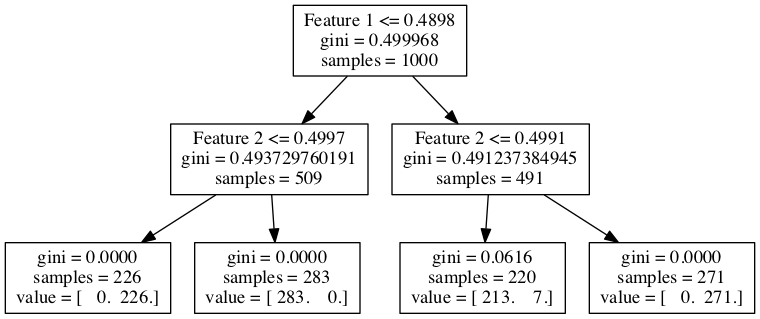

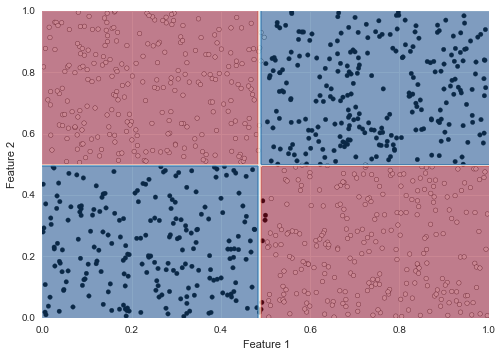

In [8]:
bumper = Bumper(n_bumps=50, random_state=5572)
bumper.fit(X_,y_)

draw_decision_regions(X_,y_, bumper.best_estimator_)
visualise_tree(bumper.best_estimator_)

Voila! We find the perfect split.

## So what? Interpretability!

So what, my gradient boosted decision trees/deep neural networks/ensemble of NN and random forests could have done this as well. This is true. The point here is that we do not need a complicated model to make perfect decision in this case.

A complex model could have done it, however you would have to think quite hard to understand what it is doing. Bumping is another tool to add to your toolbox if you want a simple model. During training it takes extra CPU time, once you have your model it is a simple one that is fast to evaluate.


## Bonus round

Let's try bumping on a more complicated pattern: a chessboard with four rows and four columns. As you can see we do considerably more rounds of bumping. The brief wait is worth it as we are rewarded with a nearly perfect pattern.

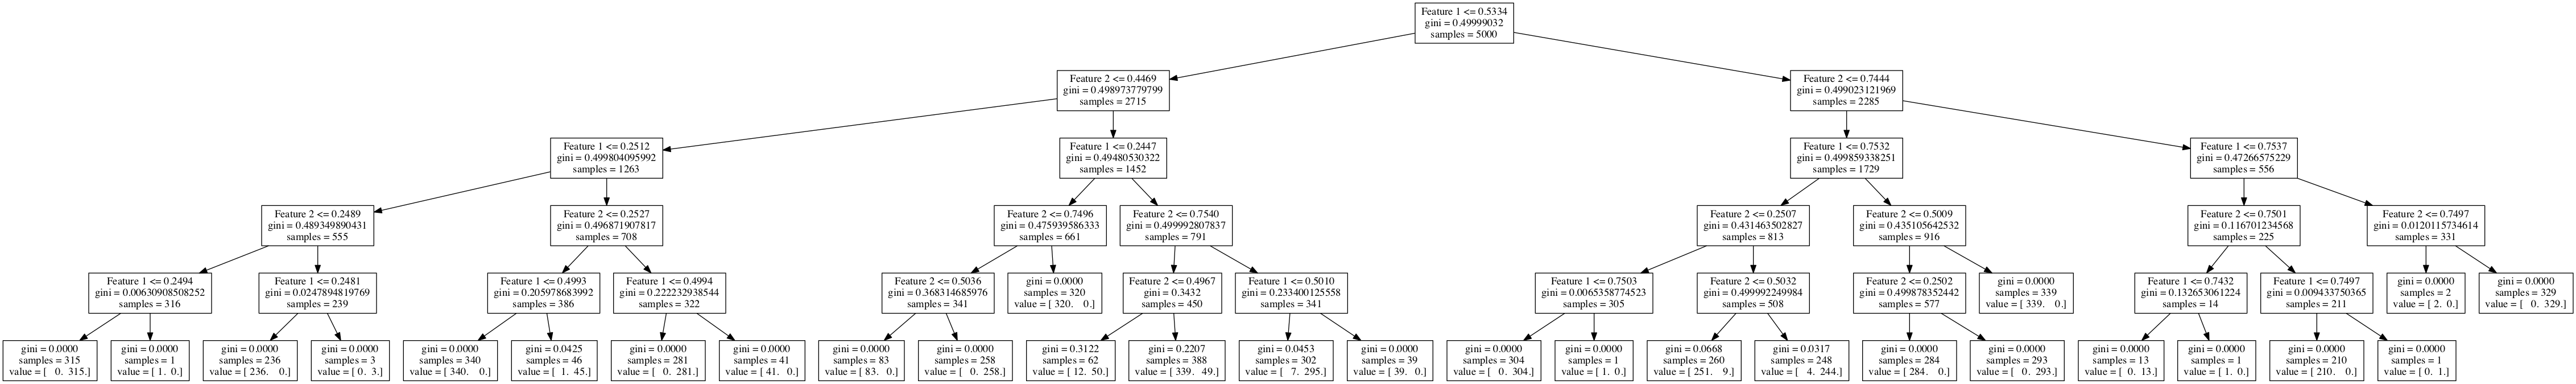

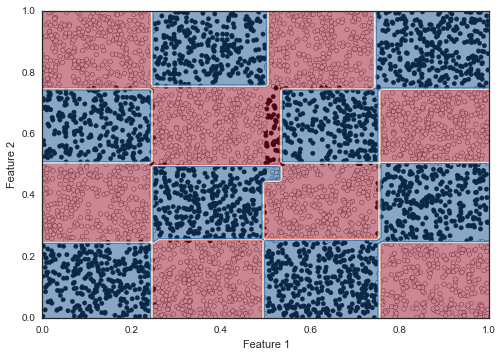

In [9]:
X4by4,y4by4 = make_chessboard(N=5000,
                              xbins=(0.,0.25,0.5,0.75,1.),
                              ybins=(0.,0.25,0.5,0.75,1.)
                             )

bumper2 = Bumper(n_bumps=1000,
                 estimator=DecisionTreeClassifier(max_depth=5),
                 random_state=457*31)
bumper2.fit(X4by4,y4by4)


with sns.axes_style('white'):
    draw_decision_regions(X4by4,y4by4,
                          bumper2.best_estimator_)
visualise_tree(bumper2.best_estimator_)

With this: have fun bumping!

I found this nice little algorithm at the end of chapter 8 of [Elements of statistical learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). Some more details are in a paper written by Tibshirani and Knight in 1999.

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)